In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected = True) # make the graph show in the notebook
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import gzip

In [8]:
with gzip.open('calendar.csv.gz', 'rt') as f:
    calendar = pd.read_csv(f)
print('There are', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'different listings')
print(calendar.date.min(), calendar.date.max())

calendar.head()

There are 365 days and 5223 different listings
2024-12-30 2025-12-29


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,164448,2024-12-30,t,$950.00,NaN,2,120
1,164448,2024-12-31,f,$950.00,NaN,2,120
2,164448,2025-01-01,f,$950.00,NaN,2,120
3,164448,2025-01-02,f,$950.00,NaN,2,120
4,164448,2025-01-03,t,$950.00,NaN,2,120


<Axes: title={'center': 'Ratio of Available Listings'}, xlabel='available'>

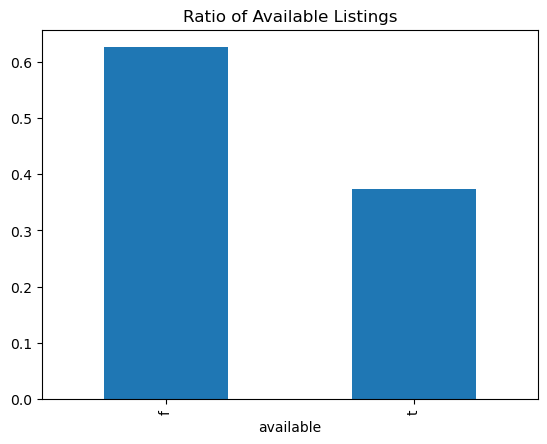

In [20]:
calendar.available.value_counts(normalize = True).plot(kind = 'bar', title = 'Ratio of Available Listings')

Text(0, 0.5, 'Ratio of Booked Listings')

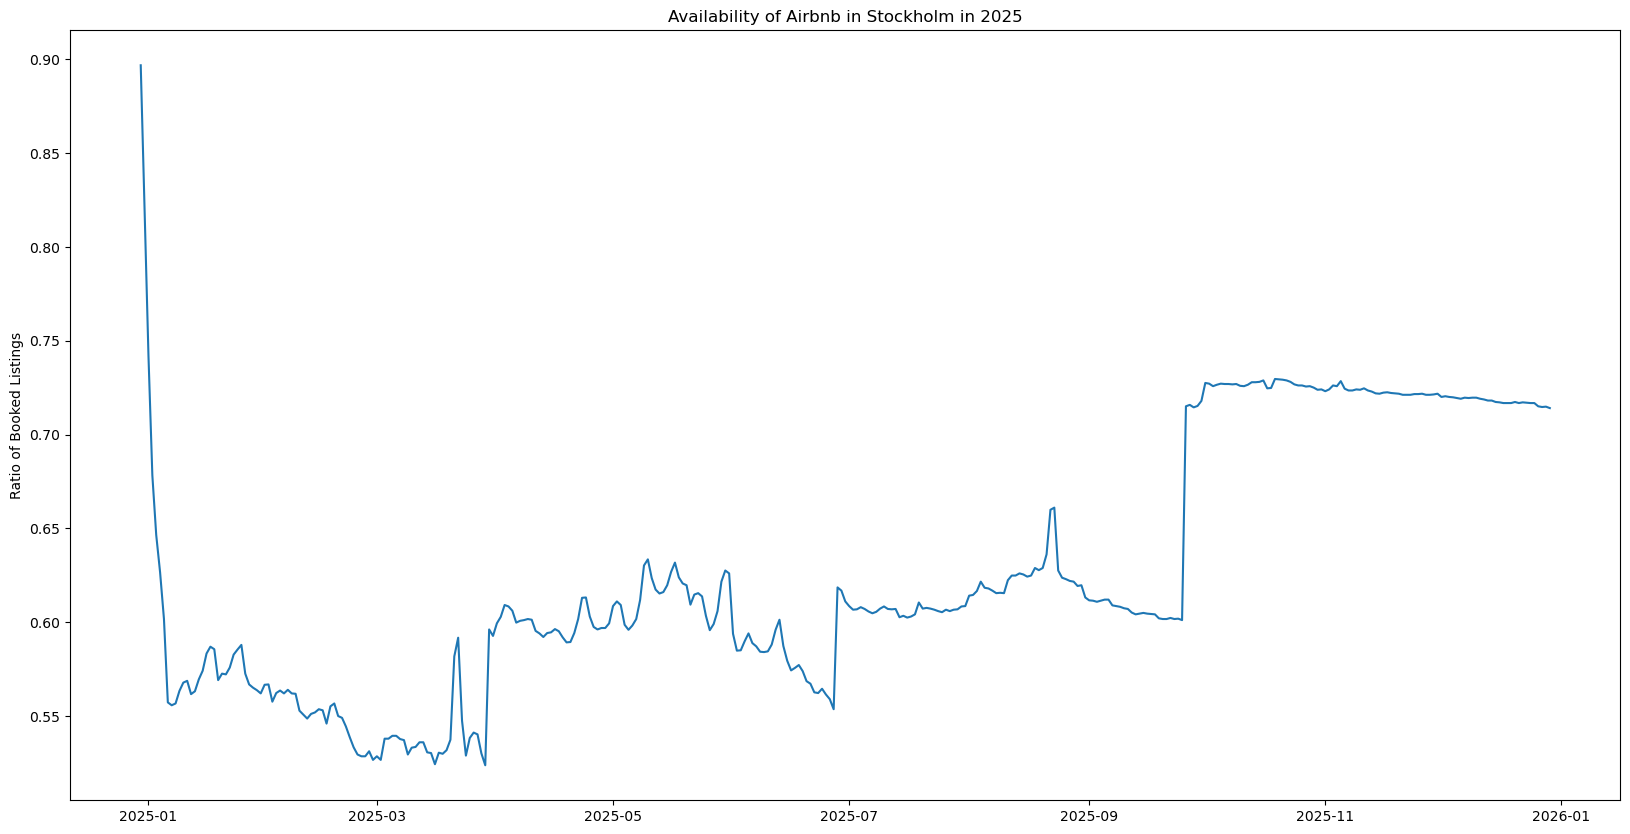

In [25]:
# add a new column called 'busy'
# if a listing is not available, it takes on value 1 otherwise 0
new_calendar = calendar[['date', 'available']]
new_calendar['busy'] = new_calendar.available.map(lambda x:0 if x == 't' else 1)
new_calendar = new_calendar.groupby('date')['busy'].mean().reset_index()
new_calendar['date'] = pd.to_datetime(new_calendar['date'])

plt.figure(figsize= (20, 10))
plt.plot(new_calendar['date'], new_calendar['busy'])
plt.title('Availability of Airbnb in Stockholm in 2025')
plt.ylabel('Ratio of Booked Listings')

Text(0, 0.5, 'Month')

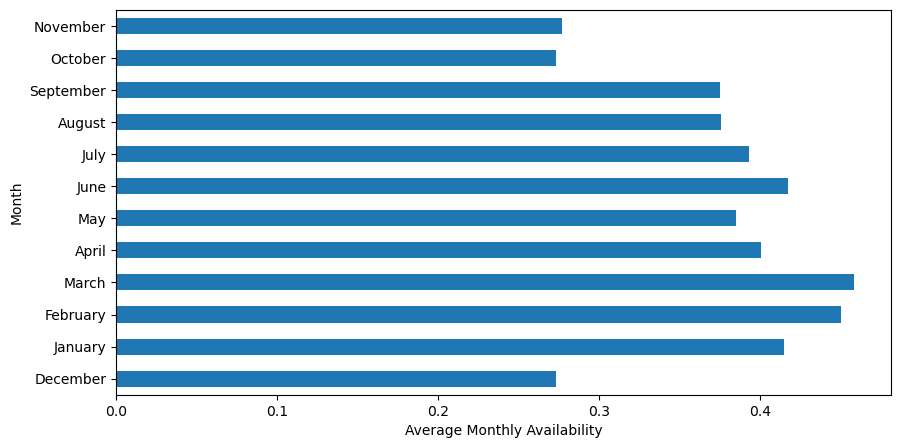

In [61]:
import datetime as dt
calendar['date'] = pd.to_datetime(calendar['date'])
# calendar['price'] = calendar['price'].str.replace('$', '').str.replace(',', '').astype(float)
calendar['booked'] = calendar.available.map(lambda x:1 if x == 't' else 0)
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'), sort = False)['booked'].mean()
mean_of_month.plot(kind = 'barh', figsize= (10, 5))
plt.xlabel('Average Monthly Availability')
plt.ylabel('Month')

Higher values suggest that higher number of available listings. From the graph it is clear

In [82]:
import plotly.express as px
calendar['dayofweek'] = calendar.date.dt.day_name()
days = calendar['dayofweek'].unique().tolist()
df_week = price_week = calendar.groupby('dayofweek')['booked'].mean().reindex(days)
df_week = df_week.reset_index()
fig3 = px.line(df_week, x = 'dayofweek', y = 'booked', title= 'Average Availability by Day of Week', labels = {'dayofweek': '', 
                                                                                                               'booked': 'Ratio of Available Listings'})
fig3.update_xaxes(tickangle= 45)
fig3.show()
# fig3 = px.line(, x = '')
# price_week.plot(title = 'Availability by Day of Week')
# plt.show()